## Setup

In [ ]:
%pip install pandas numpy matplotlib scipy

In [8]:
import pandas
import numpy

import matplotlib.pyplot as plt

from scipy import stats
from typing import Iterable


In [9]:
# H0: mean(control's SkinThickness) = mean(treatment's SkinThickness)
# H1: mean(control's SkinThickness) < mean(treatment's SkinThickness)

In [47]:
df = pandas.read_csv("yrbss.csv")

mask = df.notna()
df = df[mask["school_night_hours_sleep"] & mask["grade"]]
df["grade"] = df["grade"].astype(int)
df["school_night_hours_sleep"] = df["school_night_hours_sleep"].str.replace("+", "").str.replace("<", "").astype(int)

control = df[df["gender"] == "female"]
treatment = df[df["gender"] == "male"]


/tmp/ipykernel_220690/2154126411.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["school_night_hours_sleep"] = df["school_night_hours_sleep"].str.replace("+", "").str.replace("<", "").astype(int)


## #descriptivestats

In [48]:
columns = ["grade", "school_night_hours_sleep"]
print(df.describe()[columns])
print(control.describe()[columns])
print(treatment.describe()[columns])

           grade  school_night_hours_sleep
count  90.000000                 90.000000
mean   10.444444                  6.966667
std     1.092478                  1.310716
min     9.000000                  5.000000
25%     9.250000                  6.000000
50%    10.000000                  7.000000
75%    11.000000                  8.000000
max    12.000000                 10.000000
           grade  school_night_hours_sleep
count  47.000000                 47.000000
mean   10.510638                  6.893617
std     1.120410                  1.338949
min     9.000000                  5.000000
25%     9.500000                  6.000000
50%    11.000000                  7.000000
75%    11.000000                  8.000000
max    12.000000                 10.000000
           grade  school_night_hours_sleep
count  43.000000                 43.000000
mean   10.372093                  7.046512
std     1.069563                  1.290136
min     9.000000                  5.000000
25%     9.5

<BarContainer object of 6 artists>

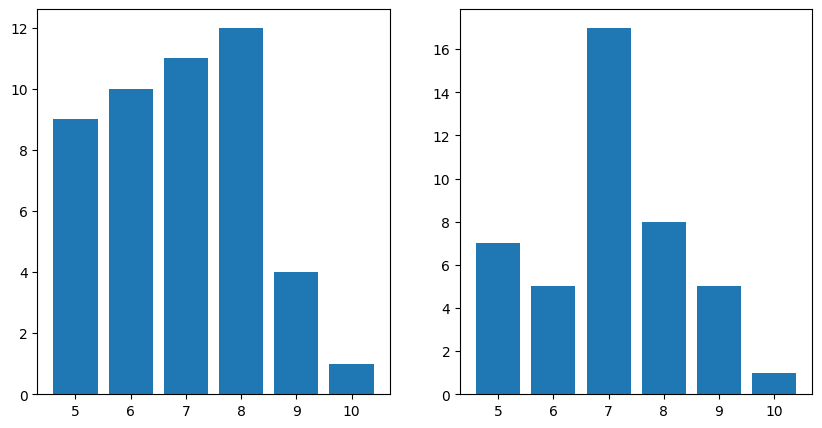

In [58]:
# Make a barchart for the control and treatment groups
# to see the distribution of the data

f, (ax1, ax2,) = plt.subplots(1, 2, figsize=(10, 5))

xs1 = control["school_night_hours_sleep"].unique()
ys1 = [control[control["school_night_hours_sleep"] == x]["school_night_hours_sleep"].count() for x in xs1]

ax1.bar(xs1, ys1)

xs2 = treatment["school_night_hours_sleep"].unique()
ys2 = [treatment[treatment["school_night_hours_sleep"] == x]["school_night_hours_sleep"].count() for x in xs2]

ax2.bar(xs2, ys2)
# ax.bar(["control", "treatment"], [control["school_night_hours_sleep"].mean(), treatment["school_night_hours_sleep"].mean()])

## #distributions

<AxesSubplot: title={'center': 'school_night_hours_sleep'}, xlabel='[grade]'>

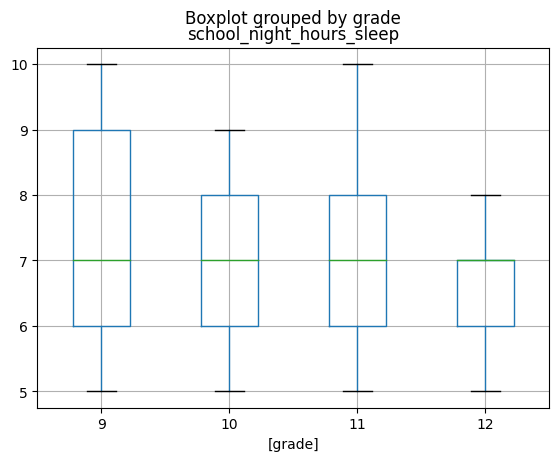

In [53]:
df[["grade", "school_night_hours_sleep"]].boxplot(by="grade")

<AxesSubplot: xlabel='grade'>

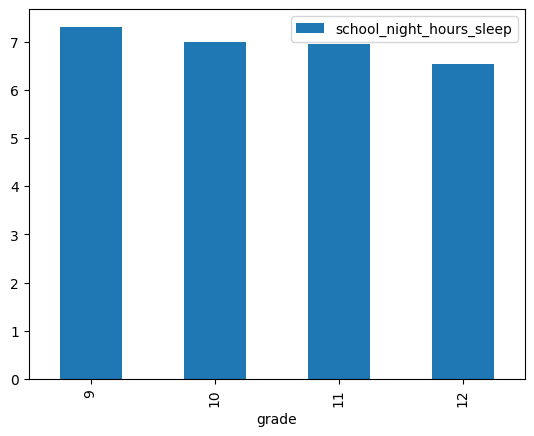

In [32]:
# Make a barchart
df[["grade", "school_night_hours_sleep"]].groupby("grade").mean().plot.bar()

## #significance

In [35]:
def difference_of_means_test(
    control: Iterable[float], treatment: Iterable[float], tails: int = 1
):
    n_1, n_2 = len(control), len(treatment)
    x_1, x_2 = numpy.mean(control), numpy.mean(treatment)

    # sample SD formula (aka Bessel’s correction): use n-1 in denominator
    s_1, s_2 = numpy.std(control, ddof=1), numpy.std(treatment, ddof=1)

    # conservative estimate from OpenIntro
    DOF = min(n_1, n_2) - 1

    SE = numpy.sqrt(s_1**2 / n_1 + s_2**2 / n_2)
    t_score = numpy.abs((x_2 - x_1)) / SE
    p_value = tails * stats.t.cdf(-t_score, DOF)

    # OpenIntro section 5.3.6
    pooled_SD = numpy.sqrt(
        (s_1**2 * (n_1 - 1) + s_2**2 * (n_2 - 1)) / (n_1 + n_2 - 2)
    )
    cohen_d = (x_2 - x_1) / pooled_SD

    return p_value, cohen_d


In [36]:
p_value, cohen_d = difference_of_means_test(
    control["school_night_hours_sleep"], treatment["school_night_hours_sleep"]
)
print(f"p-value: {p_value}, Cohen's d: {cohen_d}")


p-value: 0.08666424699196328, Cohen's d: -0.29096194778571816


## Sampling

In [ ]:
from scipy import stats

plt.rcParams.update({'font.size': 13})
plt.rcParams["figure.figsize"] = [6,4]

def plot_pop(alpha,beta,size):
    population = stats.beta.rvs(alpha,beta,size=size)*200
    # Note: running this cell again will produce a slightly different distribution.
    # ...Why? Consider investigating the rvs function further.
    plt.hist(population,color='orange')
    plt.title("Population Distribution")
    plt.ylabel('Frequency')
    plt.xlabel('X')
    print("Here's what your population distribution looks like:")
    plt.show()
    print("The population mean is:", round(numpy.mean(population),1))
    return population

def sample_procedure(dist,n,repeats):
    # this function implements the full sampling process
    # dist is the population distribution
    # n is the sample size
    
    # lots of samples:
    sample_means = []
    for i in range(repeats):
        sample = numpy.random.choice(dist, (n, ))
        this_mean = numpy.mean(sample)
        sample_means.append(this_mean)
        # if i<3:
            # print("\nSample #",i+1,":",[round(elem, 1) for elem in sample])
            # print("This sample has a mean of:",numpy.mean(sample))
    # print("\n...\n...\n\nSampling many ("+str(repeats)+") more times to approximate infinitely many samples...\n")
    
    return sample_means

def plot_sampling_dist(sample_means,dist,n,repeats):
    # this function plots the sampling distribution
    print("\nBased on",repeats,"samples of size",n,", here's what the sampling distribution of the sample mean looks like.\n")
    fig, ax = plt.subplots()
    ax.hist(sample_means,color='blue',density=1)
    x = numpy.linspace(min(sample_means)-1, max(sample_means)+1, 100)
    plt.xlim(min(x),max(x))
    # ax.plot(x, stats.norm.pdf(x, numpy.mean(sample_means), numpy.std(sample_means)),linewidth=2,color='red')
    plt.title('Sampling Distribution of the Sample Mean\nn='+str(n))
    plt.ylabel('Frequency')
    plt.xlabel('Sample Mean')    
    plt.show()
    res = stats.probplot(sample_means, plot=plt)
    plt.title('Normal Probability (QQ) Plot')
    plt.show()
    
    print("\nThe mean of the sample means is:", round(numpy.mean(sample_means),1))
    print("The standard deviation of the sample means is:", round(numpy.std(sample_means),1))

In [ ]:
a = 5
b = 2
pop_size = 1000
pop_dist = plot_pop(a,b,pop_size)

In [ ]:
sample_size = 5 # <--- try changing sample sizes
sample_repeats = 50000 # needs to be a large number (to approximate infinitely many samples)
samples = sample_procedure(pop_dist,sample_size,sample_repeats) # call the sampling procedure
plot_sampling_dist(samples,pop_dist,sample_size,sample_repeats) 

In [ ]:
# this function creates the population distribution
# def create_pop(shape):
#     # a "beta" distribution is used to create the underlying distribution
#     # a beta distribution takes two (positive) parameters (a,b)
#     # and can take various shapes depending on these values
#     # https://en.wikipedia.org/wiki/Beta_distribution
#     if shape=="uniform":
#         a,b=1,1
#     elif shape=="skewed":
#         a,b=.1,1
#     elif shape=="normal":
#         a,b=10,10
#     elif shape=="bimodal":
#         a,b=0.05,0.05
#     else:
#         return [0]
#     population = stats.beta.rvs(a, b, size=10000)*200
#     return population

# this function plots the population distribution
# def plot_pop(pop):
#     print("Here's a population of size", len(pop))
#     print("The population mean is:", round(numpy.mean(pop), 1))
#     plt.hist(pop, color="orange")
#     plt.title("Population Distribution")
#     plt.xlabel("X")
#     plt.ylabel("Frequency")
#     plt.show()


# this function implements the full sampling process
def sample_procedure(pop_dist, n, repeats):
    # print("\nTaking samples of size", n, "...")
    sample_means = []

    for i in range(repeats):
        sample = numpy.random.choice(pop_dist, n)
        # by default, numpy.random.choice uses replace=True
        this_mean = numpy.mean(sample)
        sample_means.append(this_mean)
        # if i < 3:
        #     print("\nSample #", i + 1, ":", [round(elem, 2) for elem in sample])
        #     print("This sample mean is:  ", round(this_mean, 2))
    # print("\n...\n...\nSampling many more times...\n")
    # print(
    #     "Based on",
    #     repeats,
    #     "samples, the mean of the sampling distribution is",
    #     round(numpy.mean(sample_means), 2),
    # )
    # print("and the standard error is =", round(numpy.std(sample_means), 2))
    return sample_means


# this function plots the sampling distribution
def plot_sampling_dist(means, n):
    plt.hist(means, color="blue")
    plt.title("Sampling Distribution of the Sample Mean\n" + "Sample size=" + str(n))
    plt.xlabel("Sample Mean")
    plt.ylabel("Frequency")
    plt.show()


# this function creates an upper and lower bound for a confidence interval
def confidence_interval(point_estimate, SE, conf_level):
    z = stats.norm.ppf(
        1 - (1 - conf_level) / 2
    )  # gives 1.96 for a 95% confidence level
    lowbound = point_estimate - z * SE
    highbound = point_estimate + z * SE
    return lowbound, highbound


# this function calculates the percentage of
# confidence intervals that contain the population mean
def confidence_interval_accuracy(pop_mean, means, repeats, conf_level):
    count = 0
    standard_error = numpy.std(means)
    for i in range(repeats):
        this_mean = means[i]
        low, high = confidence_interval(this_mean, standard_error, conf_level)
        # if the population parameter is inside the interval, count it
        if pop_mean > low and pop_mean < high:
            count += 1
    return count / repeats * 100


# this function evaluates the accuracy of several different
# confidence intervals for each sample and plots the result
def confidence_interval_accuracy_chart(population_mean, sample_means, sample_repeats):
    print("Allow 5-10 seconds to test all of those confidence intervals...")
    ci = [0.5, 0.6, 0.7, 0.8, 0.9]
    ci_pct = [element * 100 for element in ci]
    ci_success = []
    for conf in ci:
        ci_success.append(
            confidence_interval_accuracy(
                population_mean, sample_means, sample_repeats, conf
            )
        )
    for i in range(len(ci)):
        print(
            "With a",
            round(ci_pct[i], 0),
            "% confidence level:",
            round(ci_success[i], 2),
            "% of intervals capture the population mean",
        )
    plt.scatter(ci_pct, ci_success)
    plt.title("Confidence Interval Accuracy")
    plt.xlabel("Confidence Interval (%)")
    plt.ylabel("Percent of CIs that Include the Pop Mean")
    plt.plot([50, 99], [50, 99], "r-")
    plt.show()


# this function runs the whole sampling and evaluation procedure
def do_that_confidence_interval_thang(population, sample_size, sample_repeats):
    # First, create and plot the population distribution (in orange)
    # population = create_pop(population_shape)

    # if len(population) == 1:
    #     print(
    #         "Hey! That's not one of the choices for the shape of the population distribution"
    #     )
    #     return
    # plot_pop(population)

    # Now, run the sampling procedure many times and plot our approximation
    # of the sampling distribution of the sample means
    sample_means = sample_procedure(population, sample_size, sample_repeats)
    # plot_sampling_dist(sample_means, sample_size)

    # Finally, construct a plot to show the accuracy of various confidence intervals
    confidence_interval_accuracy_chart(
        numpy.mean(population), sample_means, sample_repeats
    )


In [ ]:
# RUN THIS CELL MULTIPLE TIMES

# SET VALUES
sample_size = 5  # try different sample sizes (e.g., n=5 and n=100)
# population_shape = "skewed"     # can be uniform, skewed, normal, or bimodal
sample_repeats = 10000  # this needs to be a large number

# CREATE THE POPULATION, SAMPLE FROM IT, AND EVALUATE THE CONFIDENCE INTERVALS
do_that_confidence_interval_thang(control["SkinThickness"], sample_size, sample_repeats)
